In [1]:
import utils
import sys
import pandas as pd
import classifiers
from matplotlib import pylab as pl
import numpy as np
from metric import clf_symdiff_normalized
from metric import clf_symdiff
import matplotlib
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

# matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

## Readme

Kernel set is specified in `get_classifier_specs()` procedure. `get_data` returns a dictionary like `{"dataset_name":(X, Y), ...}`. Margins are calculated for each kernel via `SVC.decision.function()` method

__Note__: INK-spline SVM learning process usually takes a lot of time.

## Calculating and drawing here

In [2]:

CLF_DIFF_TYPES = {
    "sn": ("SV normalized symmetric difference", clf_symdiff_normalized),
    "s": ("SV symmetric difference", clf_symdiff)
}

TEX_TABLE_BEGIN = """
\\begin{table}[H]
\\centering
\\caption{$$$$$}
\\label{my-label}
\\begin{tabular}{|l|l|l|l|l|}
\\hline
         & $\\mathrm{mean}(\\#\\mathrm{SV})$ & $\\mathrm{mean}(1 - \\mathrm{corr}(M_i, M_j))$ & $\\mathrm{mean}(\\rho_{X^l}(K_i, K_j))$ & Correlation \\\\ \\hline
"""

TEX_TABLE_END = """
\\end{tabular}
\\end{table}
"""
def margin_cov_pic(margins, clfs, C, fig, tex_info, diff_type = "sn"):
    diff = CLF_DIFF_TYPES[diff_type][1]
    clfs_num = len(clfs)
    corrs_num = round(clfs_num * (clfs_num - 1) / 2)
    corrs = np.zeros(corrs_num)
    difs = np.zeros(corrs_num)
    idx = 0
    for i in range(clfs_num):
        for j in range(i + 1, clfs_num):
            corrs[idx] = np.corrcoef(margins[:, i], margins[:, j])[0, 1]
            difs[idx] = diff(clfs[i], clfs[j])
            idx += 1
    scatter_legend = "C = %.1f" % C
    fig.scatter(difs, 1 - corrs, marker='o', s=90, label=scatter_legend, c=np.random.rand(3,1))
    sv_mean = sum([clf.n_support_[0] + clf.n_support_[1] for clf in clfs])/len(clfs)
    corr_mean = (1 - corrs).mean()
    dif_mean = difs.mean()
    corr_of_scatter = np.corrcoef((1 - corrs), difs)[0, 1]
    info = "$C=%.1f$ & $%.1f$ & $%.3f$ & $%.3f$ & $%.3f$\\\\ \\hline" %(C, sv_mean, corr_mean, dif_mean, corr_of_scatter)
    tex_info.append(info)
    return corr_mean, dif_mean

    
def spec_repr(spec):
    ret = "Kernel type: "
    if spec[0] == "linear":
        return ret + "linear"
    if spec[0] == "rbf":
        return ret + "rbf, gamma = %f" % spec[1]
    if spec[0] == "poly":
        return ret + "poly, degree = %d" % spec[1]
    if spec[0] == "ink":
        return ret + "ink, degree = %d, downer limit (a) = %f" % (spec[1], spec[2])

def print_kernel_info(C, clfs, specs, margins):
    print("C = %f" % C)
    for idx, clf in enumerate(clfs):
        print("%s\nSV number = %d" % (spec_repr(specs[idx]), clf.n_support_[0] + clf.n_support_[1]))
    print("")

def _plot_routine(diff_type):
        pl.legend(loc='upper left')
        pl.xlabel(CLF_DIFF_TYPES[diff_type][0])
        pl.ylabel("$1 - \mathrf{corr}(M_i, M_j)$")
        pl.xlim(0, 0.6)
        pl.ylim(0, 0.6)
        
def draw_corr_diff(dataset_name, C_list, filename, diff_type = "sn"):
    data = utils.get_data()
    dataset = data[dataset_name]
    print(dataset_name)
    print(dataset[0].shape)
    specs = utils.get_classifier_specs()
    fig = pl.figure(figsize=(16, 9), dpi=300)
    subplots = [(len(C_list) // 2 + len(C_list) % 2, 2, i + 1) for i in range(len(C_list))]
#    subplots = [(1, len(C_list), i + 1) for i in range(len(C_list))]
    tex_info = [TEX_TABLE_BEGIN[:]]
    tex_info[0] = tex_info[0].replace("$$$$$", dataset_name.capitalize() + " info")
    corr_means = np.zeros(len(C_list))
    dif_means = np.zeros(len(C_list))
    for idx, C in enumerate(C_list):
        ax1 = fig.add_subplot(*subplots[idx])
        clfs = classifiers.get(specs, C=C)
        utils.train_clfs(clfs, dataset[0], dataset[1])
        margins = utils.get_margins(clfs, dataset[0])
        print_kernel_info(C, clfs, specs, margins)
        corr_mean, dif_mean = margin_cov_pic(margins, clfs, C, ax1, tex_info, diff_type=diff_type)
        corr_means[idx] = corr_mean
        dif_means[idx] = dif_mean
        _plot_routine(diff_type)
    tex_info.append(TEX_TABLE_END)
    tex_info_table = "\n".join(tex_info)
    with open("../source-paper/%s.tex" % dataset_name + "_table", "w") as f:
        f.write(tex_info_table)
    print("corr_means", corr_means)
    print("dif_means", dif_means)
    print("corr_mean and dif_mean correlation: %f" % np.corrcoef(corr_means, dif_means)[0, 1])
    pl.savefig(filename)


## Wine dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


wine
(4898, 11)
C = 1.000000
Kernel type: linear
SV number = 3292
Kernel type: poly, degree = 2
SV number = 3280
Kernel type: poly, degree = 3
SV number = 3280
Kernel type: poly, degree = 4
SV number = 3280
Kernel type: rbf, gamma = 0.000100
SV number = 3280
Kernel type: rbf, gamma = 0.001000
SV number = 3280
Kernel type: rbf, gamma = 0.010000
SV number = 3283
Kernel type: rbf, gamma = 0.100000
SV number = 3294
Kernel type: rbf, gamma = 1.000000
SV number = 3288

C = 10.000000
Kernel type: linear
SV number = 3287
Kernel type: poly, degree = 2
SV number = 3290
Kernel type: poly, degree = 3
SV number = 3280
Kernel type: poly, degree = 4
SV number = 3280
Kernel type: rbf, gamma = 0.000100
SV number = 3280
Kernel type: rbf, gamma = 0.001000
SV number = 3288
Kernel type: rbf, gamma = 0.010000
SV number = 3296
Kernel type: rbf, gamma = 0.100000
SV number = 3287
Kernel type: rbf, gamma = 1.000000
SV number = 3276

C = 100.000000
Kernel type: linear
SV number = 3269
Kernel type: poly, degree =

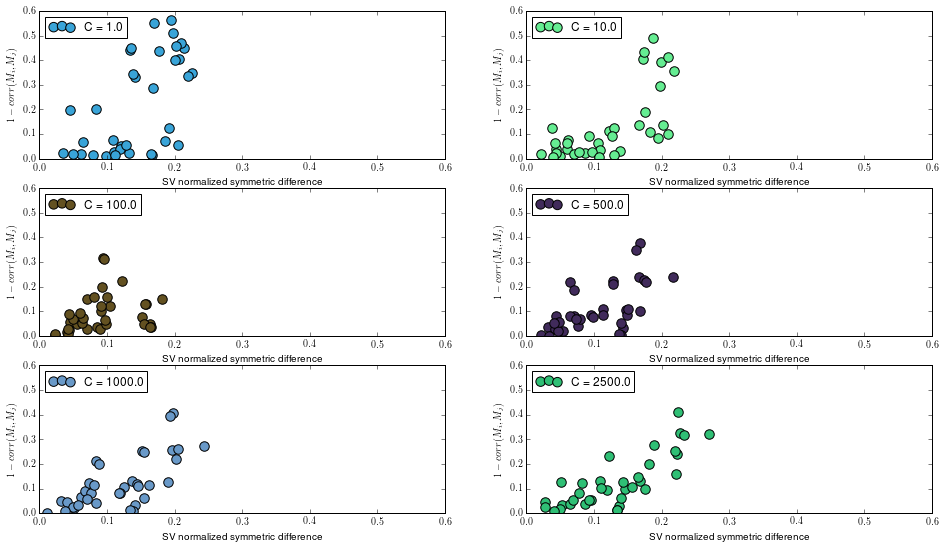

In [3]:
draw_corr_diff("wine", [1, 10, 100, 500, 1000, 2500], "../source-paper/wine.pdf")

## German dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


german
(1000, 24)
C = 1.000000
Kernel type: linear
SV number = 606
Kernel type: poly, degree = 2
SV number = 600
Kernel type: poly, degree = 3
SV number = 600
Kernel type: poly, degree = 4
SV number = 600
Kernel type: rbf, gamma = 0.000100
SV number = 600
Kernel type: rbf, gamma = 0.001000
SV number = 600
Kernel type: rbf, gamma = 0.010000
SV number = 608
Kernel type: rbf, gamma = 0.100000
SV number = 608
Kernel type: rbf, gamma = 1.000000
SV number = 609

C = 10.000000
Kernel type: linear
SV number = 605
Kernel type: poly, degree = 2
SV number = 608
Kernel type: poly, degree = 3
SV number = 600
Kernel type: poly, degree = 4
SV number = 600
Kernel type: rbf, gamma = 0.000100
SV number = 600
Kernel type: rbf, gamma = 0.001000
SV number = 606
Kernel type: rbf, gamma = 0.010000
SV number = 610
Kernel type: rbf, gamma = 0.100000
SV number = 610
Kernel type: rbf, gamma = 1.000000
SV number = 593

C = 100.000000
Kernel type: linear
SV number = 578
Kernel type: poly, degree = 2
SV number = 60

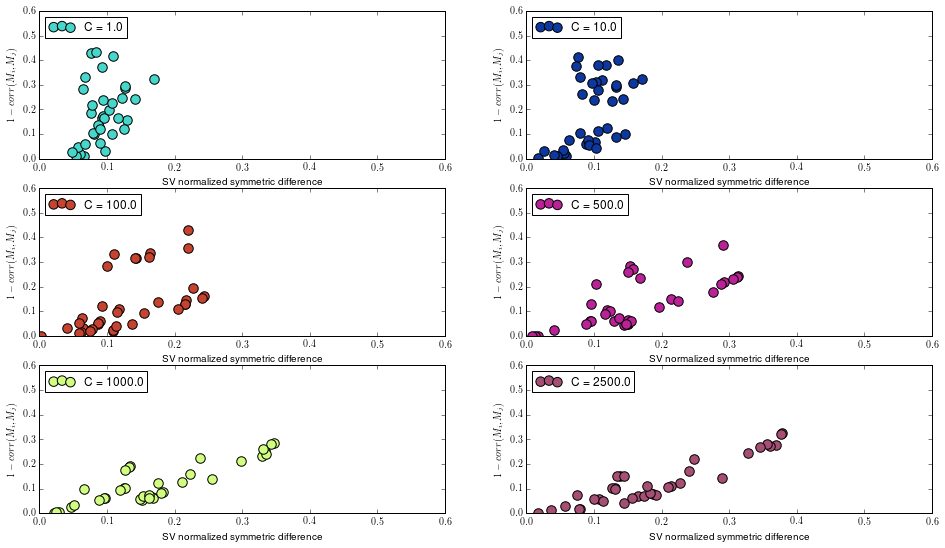

In [4]:
draw_corr_diff("german", [1, 10, 100, 500, 1000, 2500], "../source-paper/german.pdf")

## Heart dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


heart
(297, 13)
C = 1.000000
Kernel type: linear
SV number = 272
Kernel type: poly, degree = 2
SV number = 274
Kernel type: poly, degree = 3
SV number = 274
Kernel type: poly, degree = 4
SV number = 274
Kernel type: rbf, gamma = 0.000100
SV number = 274
Kernel type: rbf, gamma = 0.001000
SV number = 274
Kernel type: rbf, gamma = 0.010000
SV number = 274
Kernel type: rbf, gamma = 0.100000
SV number = 274
Kernel type: rbf, gamma = 1.000000
SV number = 258

C = 10.000000
Kernel type: linear
SV number = 227
Kernel type: poly, degree = 2
SV number = 274
Kernel type: poly, degree = 3
SV number = 274
Kernel type: poly, degree = 4
SV number = 274
Kernel type: rbf, gamma = 0.000100
SV number = 274
Kernel type: rbf, gamma = 0.001000
SV number = 274
Kernel type: rbf, gamma = 0.010000
SV number = 274
Kernel type: rbf, gamma = 0.100000
SV number = 256
Kernel type: rbf, gamma = 1.000000
SV number = 220

C = 100.000000
Kernel type: linear
SV number = 205
Kernel type: poly, degree = 2
SV number = 270


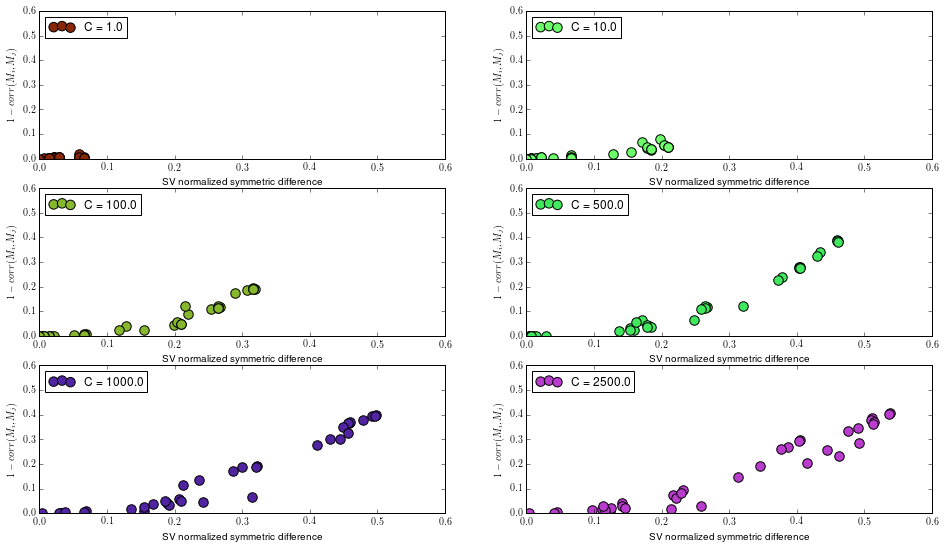

In [5]:
draw_corr_diff("heart", [1, 10, 100, 500, 1000, 2500], "../source-paper/heart.pdf")

## Spambase dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


spambase
(4601, 57)
C = 1.000000
Kernel type: linear
SV number = 3297
Kernel type: poly, degree = 2
SV number = 3626
Kernel type: poly, degree = 3
SV number = 3626
Kernel type: poly, degree = 4
SV number = 3626
Kernel type: rbf, gamma = 0.000100
SV number = 3626
Kernel type: rbf, gamma = 0.001000
SV number = 3627
Kernel type: rbf, gamma = 0.010000
SV number = 3631
Kernel type: rbf, gamma = 0.100000
SV number = 3562
Kernel type: rbf, gamma = 1.000000
SV number = 3170

C = 10.000000
Kernel type: linear
SV number = 2792
Kernel type: poly, degree = 2
SV number = 3628
Kernel type: poly, degree = 3
SV number = 3626
Kernel type: poly, degree = 4
SV number = 3626
Kernel type: rbf, gamma = 0.000100
SV number = 3628
Kernel type: rbf, gamma = 0.001000
SV number = 3631
Kernel type: rbf, gamma = 0.010000
SV number = 3559
Kernel type: rbf, gamma = 0.100000
SV number = 3166
Kernel type: rbf, gamma = 1.000000
SV number = 2515

C = 100.000000
Kernel type: linear
SV number = 2224
Kernel type: poly, degr

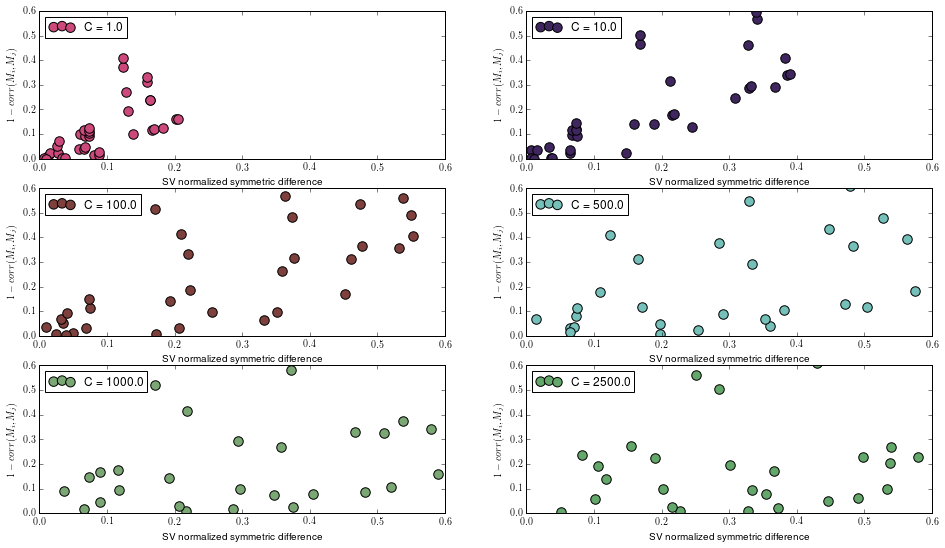

In [6]:
draw_corr_diff("spambase", [1, 10, 100, 500, 1000, 2500], "../source-paper/spambase.pdf")

## Housing dataset

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


housing
(506, 13)
C = 1.000000
Kernel type: linear
SV number = 251
Kernel type: poly, degree = 2
SV number = 250
Kernel type: poly, degree = 3
SV number = 248
Kernel type: poly, degree = 4
SV number = 248
Kernel type: rbf, gamma = 0.000100
SV number = 248
Kernel type: rbf, gamma = 0.001000
SV number = 248
Kernel type: rbf, gamma = 0.010000
SV number = 249
Kernel type: rbf, gamma = 0.100000
SV number = 252
Kernel type: rbf, gamma = 1.000000
SV number = 253

C = 10.000000
Kernel type: linear
SV number = 246
Kernel type: poly, degree = 2
SV number = 253
Kernel type: poly, degree = 3
SV number = 250
Kernel type: poly, degree = 4
SV number = 248
Kernel type: rbf, gamma = 0.000100
SV number = 248
Kernel type: rbf, gamma = 0.001000
SV number = 251
Kernel type: rbf, gamma = 0.010000
SV number = 250
Kernel type: rbf, gamma = 0.100000
SV number = 251
Kernel type: rbf, gamma = 1.000000
SV number = 238

C = 100.000000
Kernel type: linear
SV number = 226
Kernel type: poly, degree = 2
SV number = 25

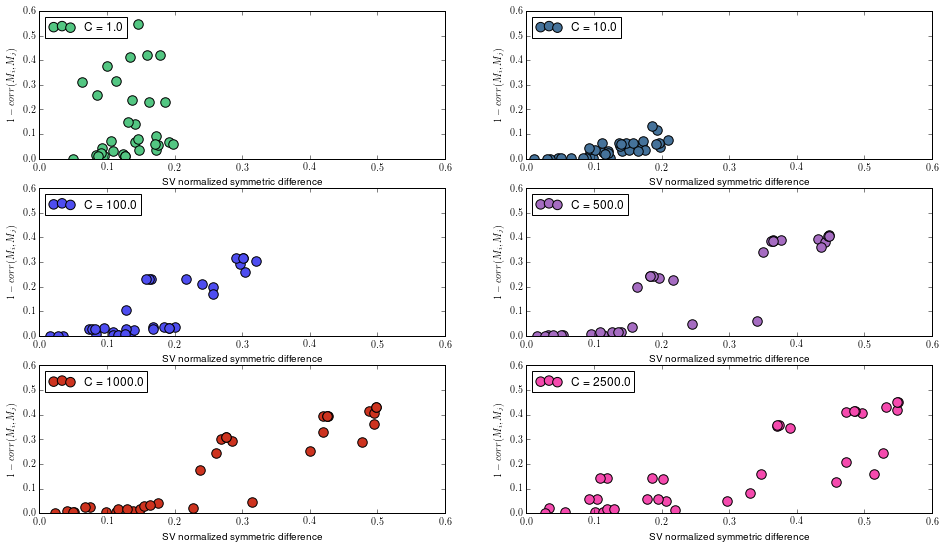

In [7]:
draw_corr_diff("housing", [1, 10, 100, 500, 1000, 2500], "../source-paper/housing.pdf")